# Однородный генератор точек для функции

## Однопоточная версия

In [2]:
import numpy as np

def generate_dataset_single_threaded(X, Y, dots_count, radius):
    dataset_X = []
    dataset_Y = []

    x_min = min(X) - radius
    y_min = min(Y) - radius
    x_max = max(X) + radius
    y_max = max(Y) + radius

    while len(dataset_X) < dots_count:
        x_rand = np.random.uniform(x_min, x_max)
        y_rand = np.random.uniform(y_min, y_max)

        within_radius = False
        for i in range(len(X)):
            x_func = X[i]
            y_func = Y[i]
            if (x_rand - x_func)**2  + (y_rand - y_func)**2 <= radius**2:
                within_radius = True
                break
        
        if within_radius == False:
            continue
        
        dataset_X.append([x_rand])
        dataset_Y.append([y_rand])

    return np.array(dataset_X), np.array(dataset_Y)

## Многопоточная версиия для видеокарт

In [3]:
import torch
import numpy as np

def generate_dataset(X, Y, dots_count, radius):
    dataset_X = []
    dataset_Y = []

    x_min = min(X) - radius
    y_min = min(Y) - radius
    x_max = max(X) + radius
    y_max = max(Y) + radius

    method = 'cpu'
    if torch.cuda:
        if torch.cuda.is_available():
            method = 'cuda'

    print(method)
    device = torch.device(method)
    X = torch.tensor(X, dtype=torch.float32).to(device)
    Y = torch.tensor(Y, dtype=torch.float32).to(device)

    while len(dataset_X) < dots_count:
        x_rand = torch.empty(1).uniform_(x_min, x_max).to(device)
        y_rand = torch.empty(1).uniform_(y_min, y_max).to(device)

        within_radius = (x_rand - X)**2 + (y_rand - Y)**2 <= radius**2
        if torch.any(within_radius):
            dataset_X.append([x_rand.item()])
            dataset_Y.append([y_rand.item()])

    return np.array(dataset_X), np.array(dataset_Y)

## Простая версия

In [4]:
import numpy as np
def simple_generate_dataset(f, weights, X, dots_count, radius):
    min_x = min(X)
    max_x = max(X)
    dataset_X = np.random.rand(dots_count, 1) * (max_x - min_x) + min_x
    dataset_Y = np.array([(f(x, weights) + np.random.uniform(-1, 1) * radius) for x in dataset_X])

    return dataset_X, dataset_Y

# Отображение датасета

In [5]:
import matplotlib.pyplot as plt

def print_generated_dataset(X, Y, dataset_X, dataset_Y, radiusX = None, radiusY = None):
    plt.style.use('default')
    _ = plt.figure(figsize=(8, 8))

    x_min = min(X)
    x_max = max(X)
    y_min = min(Y)
    y_max = max(Y)
    if radiusX:
        x_min -= radiusX
        x_max += radiusX
    if radiusY:
        y_min -= radiusY
        y_max += radiusY

    # Задаем координаты вершин прямоугольника
    x = [x_min, x_min, x_max, x_max, x_min]
    y = [y_min, y_max, y_max, y_min, y_min]

    # Рисуем прямоугольник
    plt.plot(x, y)

    plt.scatter(dataset_X, dataset_Y, color='gray', alpha=0.5, s=20.8, antialiased=True)
    plt.plot()
    plt.xlabel('X')
    plt.ylabel('y')
    plt.plot(X, Y, label='Real', color='lime', antialiased=True, linewidth=1.7)


    plt.legend()
    plt.show()

# Примеры

In [6]:
import numpy as np

def f(x, w):
    return np.sin(2*x)

# Параметры
density = 8000
dots_count = 1000
dist = 1.6
radius = 0.1

# Генерируем функцию
weights = np.array([15, 3, 4, -2])
X = np.linspace(-dist, dist, density)
Y = np.array([f(x, weights) for x in X])

def mse_loss(f, w, X, y):
    y_pred = np.array([f(x, w) for x in X])
    return sum((y - y_pred) * (y - y_pred)) / len(y)

cpu
mse_loss for generate_dataset: [0.0116056]


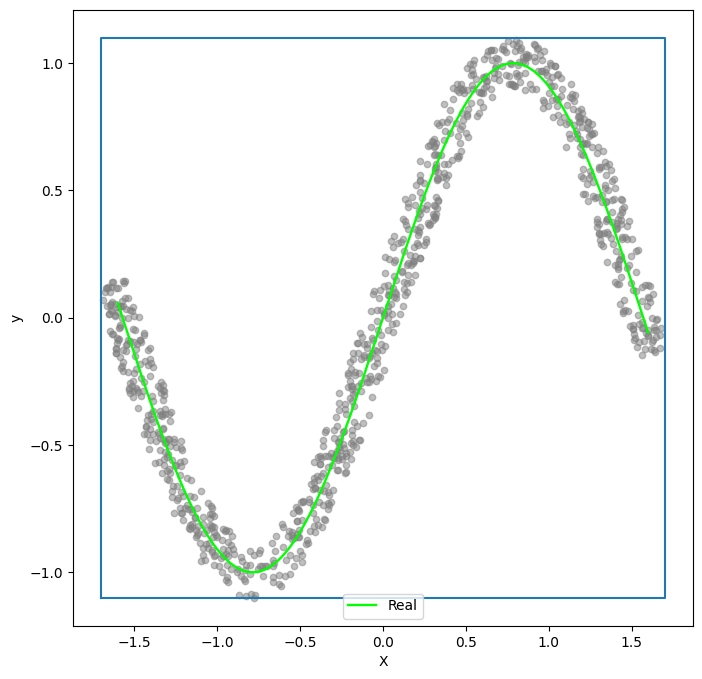

In [7]:
# Генерируем датасет
dataset_X, dataset_Y = generate_dataset(X, Y, dots_count, radius)
print("mse_loss for generate_dataset:", mse_loss(f, weights, dataset_X, dataset_Y))
print_generated_dataset(X, Y, dataset_X, dataset_Y, radius, radius)

mse_loss for simple_generate_dataset: [0.01363958]


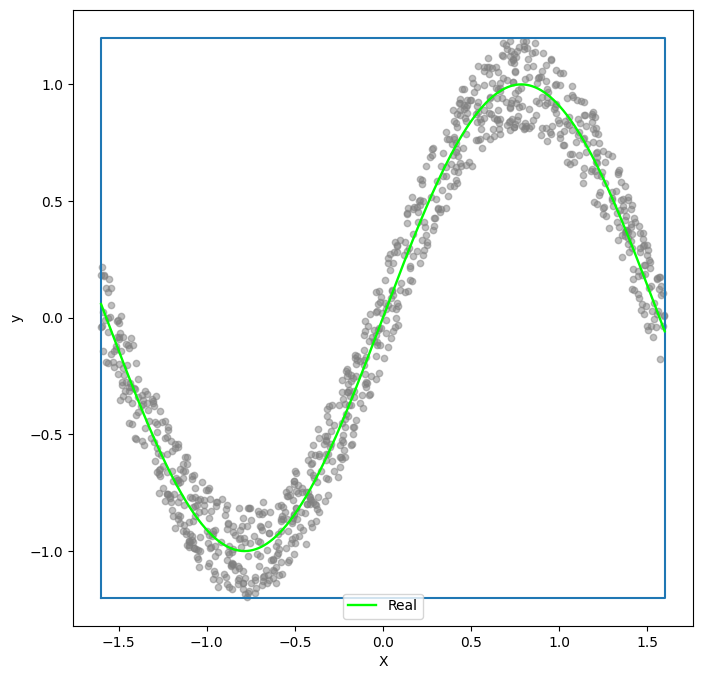

In [8]:
# Генерируем датасет

eq_radius = radius * 2

dataset_X, dataset_Y = simple_generate_dataset(f, weights, X, dots_count, eq_radius)
print("mse_loss for simple_generate_dataset:", mse_loss(f, weights, dataset_X, dataset_Y))
print_generated_dataset(X, Y, dataset_X, dataset_Y, 0, eq_radius)